<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/dev%2Ffarrel/notebooks/farrel/nb_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project Setup

## Import Libraries

In [10]:
import numpy as np
import cv2
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from scipy.ndimage import gaussian_filter, maximum_filter
from typing import Optional, Tuple, Dict, Any, Union

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Download Dataset

In [2]:
# @title Configure Kaggle secret key
!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
# @title Load Dataset in Colab
import zipfile
import os
from google.colab import drive

drive.mount('/content/drive')

# Paths
zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
drive_extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"
local_dataset_path = "/content/dataset"  # for current session

# ---------------------------
# Step 1: Download zip (if not exists in /content)
# ---------------------------
if not os.path.exists(zip_path):
    print("Dataset not found locally, downloading...")
    !kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining -p /content
else:
    print("Dataset already exists, skipping download.")

# ---------------------------
# Step 2: Extract to Google Drive (for backup)
# ---------------------------
os.makedirs(drive_extract_path, exist_ok=True)

if not os.listdir(drive_extract_path):  # Check if folder is empty
    print("Extracting dataset to Google Drive...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(drive_extract_path)
    print("Dataset extracted to:", drive_extract_path)
else:
    print("Dataset already extracted at:", drive_extract_path)

# ---------------------------
# Step 3: Copy dataset to local /content (faster training)
# ---------------------------
if not os.path.exists(local_dataset_path):
    print("Copying dataset to Colab local storage (/content)...")
    !cp -r "$drive_extract_path" "$local_dataset_path"
else:
    print("Dataset already available in Colab local storage.")

# ---------------------------
# Step 4: Define dataset paths for training
# ---------------------------
TRAIN_IMG_DIR = os.path.join(local_dataset_path, "train", "images")
TRAIN_LBL_DIR = os.path.join(local_dataset_path, "train", "labels")
TEST_IMG_DIR  = os.path.join(local_dataset_path, "test", "images")

print("Train images:", TRAIN_IMG_DIR)
print("Train labels:", TRAIN_LBL_DIR)
print("Test images:", TEST_IMG_DIR)

Mounted at /content/drive
Dataset not found locally, downloading...
 65% 135M/209M [00:00<00:00, 1.40GB/s]
100% 209M/209M [00:00<00:00, 1.41GB/s]
Dataset already extracted at: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset
Copying dataset to Colab local storage (/content)...
Train images: /content/dataset/train/images
Train labels: /content/dataset/train/labels
Test images: /content/dataset/test/images


# 2. Dataset and Density Map Generation

In [4]:
class CrowdCountingDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        label_dir: str,
        max_samples: Optional[int] = None,
        img_size: int = 224,
        downscale_factor: int = 16,
        sigma: float = 4.0,
        transform: Optional[Any] = None,
        return_meta: bool = False,
        cache_density: bool = True,
    ) -> None:
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.downscale_factor = downscale_factor
        self.sigma = sigma
        self.transform = transform
        self.return_meta = return_meta
        self.cache_density = cache_density

        # Collect image files
        all_images = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        if max_samples:
            self.image_files = all_images[:max_samples]
        else:
            self.image_files = all_images

        # Pre-load label jsons into memory (fast lookup)
        self.labels = self._load_labels()

        print(f"Using {len(self.image_files)} images for training.")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(
        self,
        idx: int
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Dict[str, Any]]:
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # ---- Load and resize image ----
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        image = cv2.resize(image, (self.img_size, self.img_size))
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        if self.transform:
            image_tensor = self.transform(image_tensor)

        # ---- Get density map (cached or computed) ----
        density_map = self._get_density_map(img_name, orig_w, orig_h)
        density_map_tensor = torch.from_numpy(density_map).unsqueeze(0)

        # Compute crowd count
        count = float(density_map_tensor.sum())

        if self.return_meta:
            return {
                "image": image_tensor,
                "density": density_map_tensor,
                "count": count,
                "name": img_name,
                "orig_size": (orig_h, orig_w),
            }
        else:
            return image_tensor, density_map_tensor

    def _load_labels(self) -> Dict[str, Dict[str, Any]]:
        """Load labels from JSON files into memory."""
        labels = {}
        for img_file in self.image_files:
            label_file = img_file.replace(".jpg", ".json")
            label_path = os.path.join(self.label_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    labels[img_file] = json.load(f)
        return labels

    def _get_density_map(self, img_name: str, orig_w: int, orig_h: int) -> np.ndarray:
        """Generate or load precomputed density map."""
        output_size = self.img_size // self.downscale_factor
        cache_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".npy"))

        # If cached density exists, just load
        if self.cache_density and os.path.exists(cache_path):
            return np.load(cache_path)

        # Otherwise, compute density map
        density_map = np.zeros((output_size, output_size), dtype=np.float32)
        label_data = self.labels.get(img_name)

        if label_data and label_data.get("human_num", 0) > 0:
            raw_points = label_data["points"]

            points = np.array([[p["x"], p["y"]] for p in raw_points], dtype=np.float32)

            for x, y in points:
                scaled_x = (x / orig_w) * output_size
                scaled_y = (y / orig_h) * output_size
                ix, iy = int(scaled_x), int(scaled_y)
                if 0 <= ix < output_size and 0 <= iy < output_size:
                    density_map[iy, ix] += 1.0

        # Apply Gaussian filter
        density_map = gaussian_filter(density_map, sigma=self.sigma / self.downscale_factor)

        # Save cache for future use
        if self.cache_density:
            np.save(cache_path, density_map)

        return density_map

# 3. Model Architecture

In [7]:
# @title Using pretrained model (VGG-16)
class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()

        # ---- Frontend (VGG-16 pretrained) ----
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        # take conv1_1 to conv4_3 (keep batch norm)

        # ---- Backend with dilated convs ----
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
        )

        # ---- Output layer ----
        self.output_layer = nn.Conv2d(64, 1, 1)

        # Init backend + output weights
        for m in self.backend.children():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        nn.init.normal_(self.output_layer.weight, std=0.01)
        nn.init.constant_(self.output_layer.bias, 0)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

# Initialize model
model = CSRNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Model architecture:")
print(model)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:02<00:00, 235MB/s]


Model parameters: 16,268,865
Model architecture:
CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

# 4. Data Loading and Training Setup

In [8]:
train_dataset = CrowdCountingDataset(
  image_dir=TRAIN_IMG_DIR,
  label_dir=TRAIN_LBL_DIR,
  img_size=224,
  downscale_factor=16,
  sigma=4.0,
  cache_density=True,
)

train_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=True,
  num_workers=4,
  pin_memory=True,
)

# Loss and Optimizer
criterion = nn.MSELoss() # Pixel-wise MSE for density map regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using 1900 images for training.


# 5. Model Training

Starting training...
Epoch 1/100, Loss: 6.787136
Epoch 5/100, Loss: 3.810196
Epoch 10/100, Loss: 2.661920
Epoch 15/100, Loss: 1.638467
Epoch 20/100, Loss: 1.579007
Epoch 25/100, Loss: 1.179810
Epoch 30/100, Loss: 0.952816
Epoch 35/100, Loss: 0.828185
Epoch 40/100, Loss: 0.743285
Epoch 45/100, Loss: 0.725010
Epoch 50/100, Loss: 0.503369
Epoch 55/100, Loss: 0.613452
Epoch 60/100, Loss: 0.409041
Epoch 65/100, Loss: 0.227084
Epoch 70/100, Loss: 0.323034
Epoch 75/100, Loss: 0.218824
Epoch 80/100, Loss: 0.225464
Epoch 85/100, Loss: 0.256032
Epoch 90/100, Loss: 0.117036
Epoch 95/100, Loss: 0.123273
Epoch 100/100, Loss: 0.178877
Training completed!


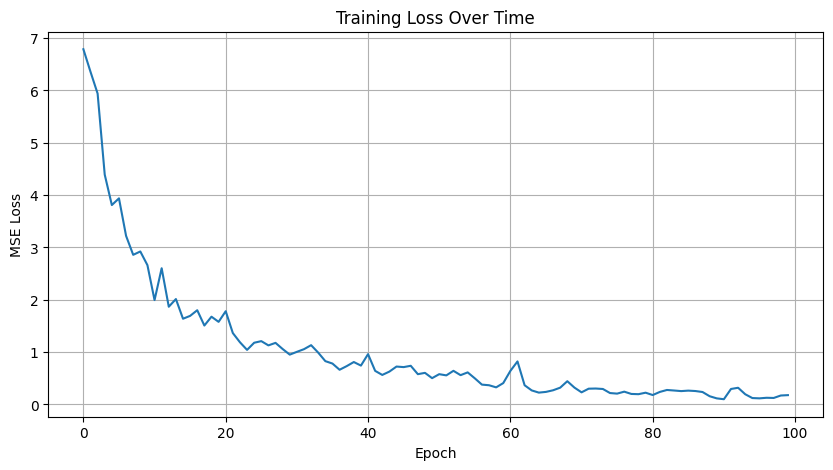

In [11]:
num_epochs = 100
training_losses = []

print("Starting training...")
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, density_maps in train_loader:
        images = images.to(device)
        density_maps = density_maps.to(device)

        # Forward pass
        optimizer.zero_grad()
        pred_density_maps = model(images)

        # Resize model output to match ground truth
        pred_density_maps = F.interpolate(
          pred_density_maps,
          size=density_maps.shape[2:],
          mode='bilinear',
          align_corners=False
        )

        # Calculate loss
        loss = criterion(pred_density_maps, density_maps)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')

print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# 6. Model Evaluation

In [12]:
# @title Helper functions for model evaluation
def predict_count(
    model: torch.nn.Module,
    image_path: str,
    device: torch.device,
    img_size: int = 224
) -> Tuple[np.ndarray, float, np.ndarray]:
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (img_size, img_size))
    input_tensor = torch.from_numpy(resized_image).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        pred_density_map = model(input_tensor)

    # The predicted count is the sum of the density map
    predicted_count = pred_density_map.sum().item()

    return image, predicted_count, pred_density_map.squeeze().cpu().numpy()

def get_ground_truth_count(image_name: str, label_dir: str) -> int:
    label_file = image_name.replace('.jpg', '.json')
    label_path = os.path.join(label_dir, label_file)
    if not os.path.exists(label_path):
        # For test set, we might not have labels. We'll use train labels for MAE calculation.
        return 0
    with open(label_path, 'r') as f:
        data = json.load(f)
    return data['human_num']

def visualize_detections(
    original_image: np.ndarray,
    pred_map: np.ndarray,
    pred_count: float,
    true_count: int,
    img_name: str,
    downscale_factor: int = 16,
    threshold_scale: float = 2.0
) -> None:
    """
    Finds peaks in the density map and draws circles on the original image.
    """
    # Find local maxima in the density map
    footprint = np.ones((3, 3))
    local_max = maximum_filter(pred_map, footprint=footprint) == pred_map

    # Apply a threshold to filter out weak peaks
    threshold = pred_map.mean() * threshold_scale
    peaks = (pred_map > threshold) & local_max

    # Get coordinates of the peaks
    peak_coords = np.argwhere(peaks) # (row, col) format

    # --- Visualization ---
    plt.figure(figsize=(10, 8))

    # Draw circles on the original image
    img_with_circles = original_image.copy()
    orig_h, orig_w = img_with_circles.shape[:2]

    for y_map, x_map in peak_coords:
        # Scale coordinates from map size back to original image size
        x_orig = int((x_map + 0.5) * downscale_factor * (orig_w / 224))
        y_orig = int((y_map + 0.5) * downscale_factor * (orig_h / 224))

        # Draw a red circle
        cv2.circle(img_with_circles, (x_orig, y_orig), radius=15, color=(255, 0, 0), thickness=3)

    plt.imshow(img_with_circles)
    plt.title(f'Detections for: {img_name}\nPredicted Count: {pred_count:.2f} | Ground Truth: {true_count}', fontsize=14)
    plt.axis('off')
    plt.show()

Evaluating model on training images (to check learning)...


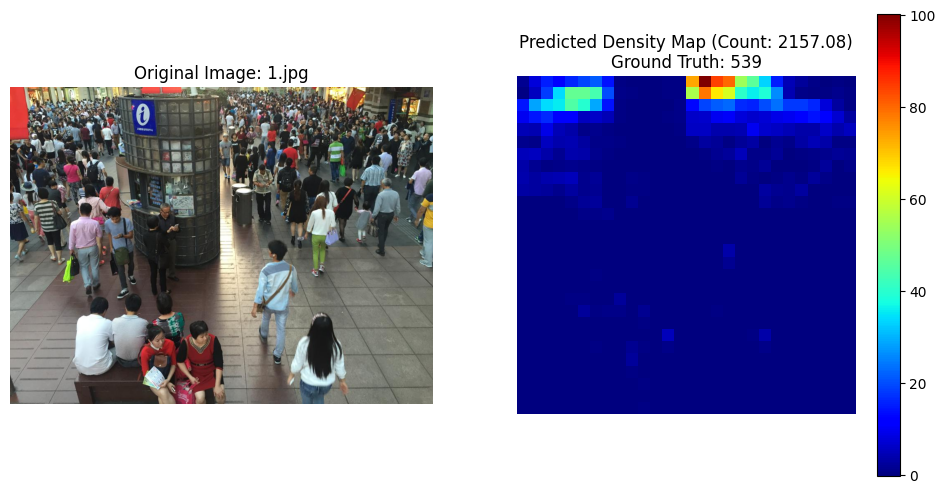

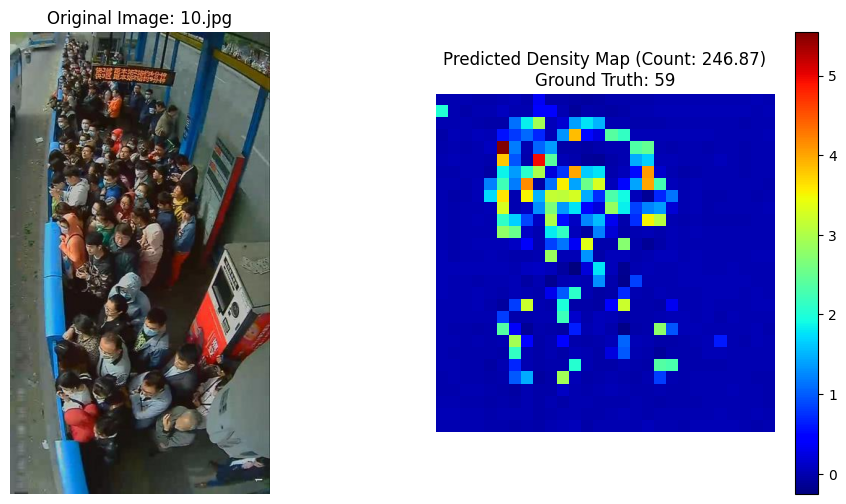

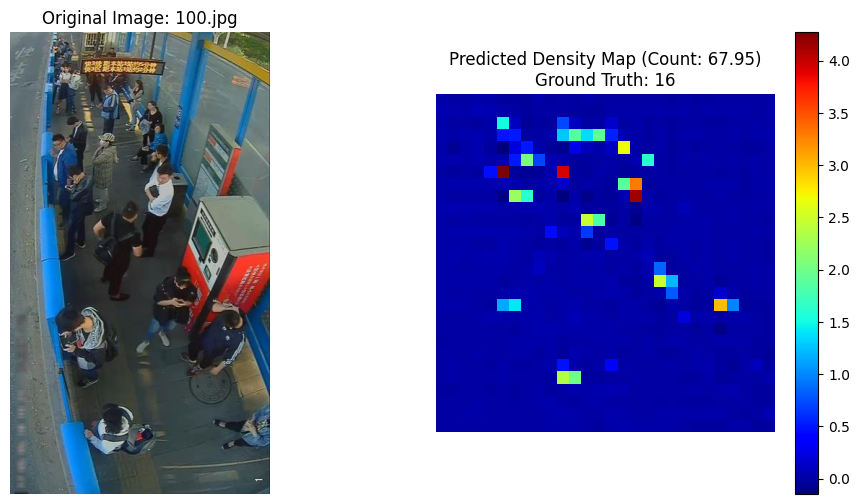


Evaluation Results on Training Sample:
   image_name  true_count   pred_count
0       1.jpg         539  2157.076416
1      10.jpg          59   246.866974
2     100.jpg          16    67.947723
3    1000.jpg          30   121.439377
4    1001.jpg         363  1549.515137
5    1002.jpg         232  1029.904663
6    1003.jpg         206   908.903687
7    1004.jpg         316  1387.905029
8    1005.jpg           6    26.828346
9    1006.jpg           6    29.216127
10   1007.jpg          35   146.757095
11   1008.jpg          26   100.792824
12   1009.jpg         223   906.471558
13    101.jpg          12    45.952709
14   1010.jpg          83   319.214539
15   1011.jpg         240  1047.175903
16   1012.jpg          24    35.523834
17   1013.jpg           5    20.805550
18   1014.jpg          16    64.128212
19   1015.jpg          28   106.753769
20   1016.jpg         177   730.480774
21   1017.jpg          12    54.085850
22   1018.jpg           7    36.833588
23   1019.jpg          2

In [13]:
# @title Evaluating model
print("Evaluating model on training images (to check learning)...")
print("=" * 50)

evaluation_results = []
sample_images_for_eval = train_dataset.image_files[:30]

for img_name in sample_images_for_eval:
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)

    # Get ground truth
    true_count = get_ground_truth_count(img_name, TRAIN_LBL_DIR)

    # Get prediction
    original_image, pred_count, pred_map = predict_count(model, img_path, device)

    evaluation_results.append({
        'image_name': img_name,
        'true_count': true_count,
        'pred_count': pred_count
    })

    # Visualize first 3 images
    if len(evaluation_results) <= 3:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(original_image)
        ax1.set_title(f'Original Image: {img_name}')
        ax1.axis('off')

        im = ax2.imshow(pred_map, cmap='jet')
        ax2.set_title(f'Predicted Density Map (Count: {pred_count:.2f})\nGround Truth: {true_count}')
        ax2.axis('off')
        fig.colorbar(im, ax=ax2)
        plt.show()

# Calculate and display MAE
eval_df = pd.DataFrame(evaluation_results)
mae = (eval_df['pred_count'] - eval_df['true_count']).abs().mean()

print("\nEvaluation Results on Training Sample:")
print(eval_df)
print(f"\nMean Absolute Error (MAE): {mae:.4f}")

# 7. Final Submission Generation

In [14]:
print("Generating submission file for the test set...")

test_images = sorted(
    [f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.jpg')],
    key=lambda x: int(os.path.splitext(x)[0])
)
submission_data = []

for img_name in test_images:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    _, pred_count, _ = predict_count(model, img_path, device)

    submission_data.append({
        'image_id': img_name,
        'predicted_count': int(round(pred_count))
    })

submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
print("\nFirst 5 rows of submission:")
print(submission_df.head())

Generating submission file for the test set...
Submission file 'submission.csv' created successfully.

First 5 rows of submission:
  image_id  predicted_count
0    1.jpg               69
1    2.jpg               99
2    3.jpg              855
3    4.jpg             7184
4    5.jpg              800
